Subscriber_2-sub : features=[0, 0, 1, 0, 0.0, 0] | target=0.00111
Publisher_3-pub : features=[0, 1, 0, 0, 0.0, 1] | target=0.0
Publisher_3-timer : features=[1, 0, 0, -1, 1000.0, 0] | target=0.99991


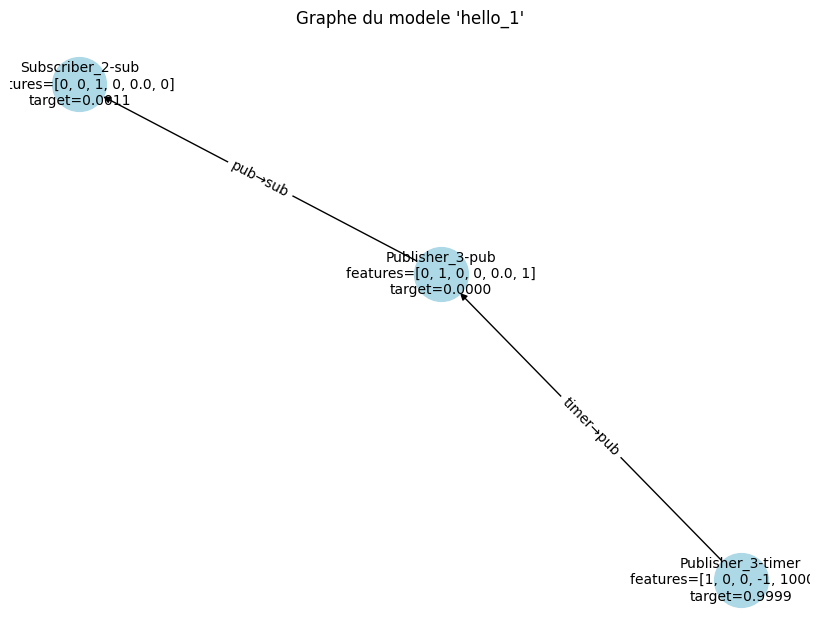

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/dataset.csv")
model_name = "hello_1"
group = df[df["ModelName"] == model_name]

action_type_onehot = {
    'timer': [1, 0, 0],
    'pub': [0, 1, 0],
    'sub': [0, 0, 1],
}

unique_topics = df["Topic"].dropna().unique()
topic_to_id = {topic: i for i, topic in enumerate(unique_topics)}

G = nx.DiGraph()

for idx, row in group.iterrows():
    node_id = f'{row["NodeName"]}-{row["ActionType"]}'

    one_hot = action_type_onehot[row["ActionType"]]

    topic_id = topic_to_id.get(row["Topic"], -1)

    period = row["Value"] if row["ActionType"] == "timer" else 0.0

    feature_vector = one_hot + [topic_id, period, row["ActionOrder"]]

    G.add_node(
        node_id,
        label=node_id,
        features=feature_vector,
        target=row["ExecutionTime"],
        node=row["NodeName"],
        topic=row["Topic"]
    )

# timer → pub (même node)
timers = group[group["ActionType"] == "timer"]
publishers = group[group["ActionType"] == "pub"]
subscribers = group[group["ActionType"] == "sub"]

for _, timer in timers.iterrows():
    for _, pub in publishers.iterrows():
        if timer["NodeName"] == pub["NodeName"]:
            src = f'{timer["NodeName"]}-timer'
            dst = f'{pub["NodeName"]}-pub'
            G.add_edge(src, dst, label="timer→pub")

# pub → sub (même topic)
for _, pub in publishers.iterrows():
    for _, sub in subscribers.iterrows():
        if pub["Topic"] == sub["Topic"]:
            src = f'{pub["NodeName"]}-pub'
            dst = f'{sub["NodeName"]}-sub'
            G.add_edge(src, dst, label="pub→sub")


for _, pub1 in publishers.iterrows():
    for _, pub2 in publishers.iterrows():
        if pub1["NodeName"] == pub2["NodeName"] and pub1["ActionOrder"] < pub2["ActionOrder"]:
            G.add_edge(f'{pub1["NodeName"]}-pub', f'{pub2["NodeName"]}-pub', label="pub→pub")

for node_id, data in G.nodes(data=True):
    print(f"{node_id} : features={data['features']} | target={data['target']}")

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
labels = nx.get_node_attributes(G, 'label')
node_labels = {
    n: f"{d['label']}\nfeatures={d['features']}\ntarget={d['target']:.4f}"
    for n, d in G.nodes(data=True)
}
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='lightblue', node_size=1500, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'label')

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"Graphe du modele '{model_name}'")
plt.show()


In [1]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import torch
import numpy as np
import pandas as pd
import networkx as nx

df = pd.read_csv("dataset/dataset.csv")

node_keys = sorted(set(f'{row["NodeName"]}-{row["ActionType"]}' for _, row in df.iterrows()))
node_to_idx = {k: i for i, k in enumerate(node_keys)}

topic_to_id = {topic: i for i, topic in enumerate(df["Topic"].dropna().unique())}
action_type_onehot = {'timer': [1, 0, 0], 'pub': [0, 1, 0], 'sub': [0, 0, 1]}

G = nx.DiGraph()
G.add_nodes_from(node_keys)

for model_name in df["ModelName"].unique():
    group = df[df["ModelName"] == model_name]
    
    for _, timer in group[group["ActionType"] == "timer"].iterrows():
        for _, pub in group[group["ActionType"] == "pub"].iterrows():
            if timer["NodeName"] == pub["NodeName"]:
                G.add_edge(f'{timer["NodeName"]}-timer', f'{pub["NodeName"]}-pub')
                
    for _, pub in group[group["ActionType"] == "pub"].iterrows():
        for _, sub in group[group["ActionType"] == "sub"].iterrows():
            if pub["Topic"] == sub["Topic"]:
                G.add_edge(f'{pub["NodeName"]}-pub', f'{sub["NodeName"]}-sub')

adj = nx.to_numpy_array(G, nodelist=node_keys)
edge_index = torch.tensor(np.array(adj).nonzero(), dtype=torch.long)
edge_weight = torch.tensor(adj[adj != 0], dtype=torch.float)

features_list = []
targets_list = []

for model_name in df["ModelName"].unique():
    group = df[df["ModelName"] == model_name]
    
    features = np.zeros((len(node_keys), 6))  
    targets = np.zeros((len(node_keys), 1))
    
    for _, row in group.iterrows():
        node_id = f'{row["NodeName"]}-{row["ActionType"]}'
        idx = node_to_idx[node_id]
        
        one_hot = action_type_onehot[row["ActionType"]]
        topic_id = topic_to_id.get(row["Topic"], -1)
        period = row["Value"] if row["ActionType"] == "timer" else 0.0
        order = row["ActionOrder"]
        exec_time = row["ExecutionTime"]
        
        features[idx] = one_hot + [topic_id, period, order]
        targets[idx] = [exec_time]
    
    features_list.append(features)
    targets_list.append(targets)

dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features_list,
    targets=targets_list
)
print("Dataset created with", len(features_list), "snapshots.")
print(dataset[1])


Dataset created with 477 snapshots.
Data(x=[1431, 6], edge_index=[2, 954], edge_attr=[954], y=[1431, 1])


C:\Users\annad\AppData\Local\Temp\ipykernel_17156\842374052.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  edge_index = torch.tensor(np.array(adj).nonzero(), dtype=torch.long)


✓ Graphe pour 'hello_0' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_1' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_2' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_3' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_4' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_5' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_6' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_7' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_8' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_9' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_10' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_11' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_12' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_13' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_14' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_15' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_16' créé avec 3 nœuds et 2 arêtes.
✓ Graphe pour 'hello_17' créé avec 3 nœuds et 2 arêtes.
✓ 

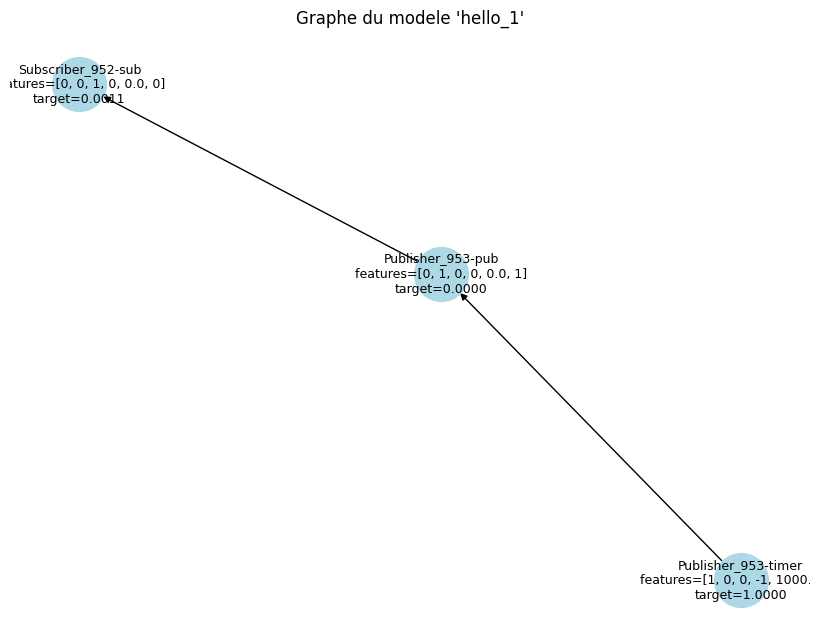

Modèle: hello_0
  Snapshot 1:
    Nœud 0: [0. 0. 1. 0. 0. 0.]
    Nœud 1: [0. 1. 0. 0. 0. 1.]
    Nœud 2: [   1.    0.    0.   -1. 1000.    0.]

Modèle: hello_1
  Snapshot 1:
    Nœud 0: [0. 0. 1. 0. 0. 0.]
    Nœud 1: [0. 1. 0. 0. 0. 1.]
    Nœud 2: [   1.    0.    0.   -1. 1000.    0.]

Modèle: hello_2
  Snapshot 1:
    Nœud 0: [0. 0. 1. 0. 0. 0.]
    Nœud 1: [0. 1. 0. 0. 0. 1.]
    Nœud 2: [   1.    0.    0.   -1. 1000.    0.]

Modèle: hello_3
  Snapshot 1:
    Nœud 0: [0. 0. 1. 0. 0. 0.]
    Nœud 1: [0. 1. 0. 0. 0. 1.]
    Nœud 2: [   1.    0.    0.   -1. 1000.    0.]

Modèle: hello_4
  Snapshot 1:
    Nœud 0: [0. 0. 1. 0. 0. 0.]
    Nœud 1: [0. 1. 0. 0. 0. 1.]
    Nœud 2: [   1.    0.    0.   -1. 1000.    0.]

Modèle: hello_5
  Snapshot 1:
    Nœud 0: [0. 0. 1. 0. 0. 0.]
    Nœud 1: [0. 1. 0. 0. 0. 1.]
    Nœud 2: [   1.    0.    0.   -1. 1000.    0.]

Modèle: hello_6
  Snapshot 1:
    Nœud 0: [0. 0. 1. 0. 0. 0.]
    Nœud 1: [0. 1. 0. 0. 0. 1.]
    Nœud 2: [   1.    0.    0.   -1.

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

df = pd.read_csv("dataset/dataset.csv")

action_type_onehot = {
    'timer': [1, 0, 0],
    'pub': [0, 1, 0],
    'sub': [0, 0, 1],
}

unique_topics = df["Topic"].dropna().unique()
topic_to_id = {topic: i for i, topic in enumerate(unique_topics)}

graphs = {}

for model_name in df["ModelName"].unique():
    group = df[df["ModelName"] == model_name]

    G = nx.DiGraph()
    node_features = []
    targets = []
    node_index_map = {}

    for idx, row in group.iterrows():
        node_id = f'{row["NodeName"]}-{row["ActionType"]}'
        if node_id not in node_index_map:
            node_index = len(node_index_map)
            node_index_map[node_id] = node_index

            one_hot = action_type_onehot[row["ActionType"]]
            topic_id = topic_to_id.get(row["Topic"], -1)
            period = row["Value"] if row["ActionType"] == "timer" else 0.0
            feature_vector = one_hot + [topic_id, period, row["ActionOrder"]]

            G.add_node(node_id, features=feature_vector, target=row["ExecutionTime"])
            node_features.append(feature_vector)
            targets.append(row["ExecutionTime"])

    # timer → pub (same node)
    timers = group[group["ActionType"] == "timer"]
    publishers = group[group["ActionType"] == "pub"]
    subscribers = group[group["ActionType"] == "sub"]

    for _, timer in timers.iterrows():
        for _, pub in publishers.iterrows():
            if timer["NodeName"] == pub["NodeName"]:
                src = f'{timer["NodeName"]}-timer'
                dst = f'{pub["NodeName"]}-pub'
                G.add_edge(src, dst)

    # pub → sub (same topic)
    for _, pub in publishers.iterrows():
        for _, sub in subscribers.iterrows():
            if pub["Topic"] == sub["Topic"]:
                src = f'{pub["NodeName"]}-pub'
                dst = f'{sub["NodeName"]}-sub'
                G.add_edge(src, dst)

    for _, pub1 in publishers.iterrows():
        for _, pub2 in publishers.iterrows():
            if pub1["NodeName"] == pub2["NodeName"] and pub1["ActionOrder"] < pub2["ActionOrder"]:
                src = f'{pub1["NodeName"]}-pub'
                dst = f'{pub2["NodeName"]}-pub'
                G.add_edge(src, dst)

    edge_index = np.array([
        [node_index_map[src], node_index_map[dst]]
        for src, dst in G.edges()
    ]).T 

    features = np.array(node_features, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)

    target_sequence = [targets for _ in range(1)]  

    dataset = StaticGraphTemporalSignal(
        edge_index=edge_index,
        edge_weight=edge_weight,
        features=[features],  
        targets=target_sequence
    )
 
    graphs[model_name] = dataset
    print(f"✓ Graphe pour '{model_name}' créé avec {features.shape[0]} nœuds et {edge_index.shape[1]} arêtes.")
    

def print_graph_info(graphs):
    for model_name, dataset in graphs.items():
        print(f"Modèle: {model_name}")
        print(f"  Nombre de nœuds: {dataset.features[0].shape[0]}")
        print(f"  Nombre d'arêtes: {dataset.edge_index.shape[1]}")
        print(f"  Dimensions des caractéristiques: {dataset.features[0].shape[1]}")
        print(f"  Dimensions des cibles: {dataset.targets[0].shape[1]}")
        print()

def print_features(graphs):
    for model_name, dataset in graphs.items():
        print(f"Modèle: {model_name}")
        for i, features in enumerate(dataset.features):
            print(f"  Snapshot {i+1}:")
            for j, feature in enumerate(features):
                print(f"    Nœud {j}: {feature}")
        print()


def visualize_graph(G, model_name):
    import matplotlib.pyplot as plt

    pos = nx.spring_layout(G, seed=42)
    node_labels = {
        n: f"{n}\nfeatures={d['features']}\ntarget={d['target']:.4f}"
        for n, d in G.nodes(data=True)
    }
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='lightblue', node_size=1500, font_size=9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
    plt.title(f"Graphe du modele '{model_name}'")
    plt.show()

visualize_graph(G, 'hello_1')
print_features(graphs)
